In [21]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


In [22]:
X_train = np.loadtxt("dataset/train/X_train.txt")
y_train = np.loadtxt("dataset/train/y_train.txt", dtype=int) - 1 # Adjust labels to start at 0
X_test = np.loadtxt("dataset/test/X_test.txt")
y_test = np.loadtxt("dataset/test/y_test.txt", dtype=int) - 1 # Adjust labels to start at 0
train_set = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_set = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))


In [23]:
def hinge_loss():
    return

def train(train_set, model, criterion, epochs=10, lr=0.01, reg_lambda=0.001, print_epoch=False):
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            outputs = model(X)
            if criterion == hinge_loss:
                loss = criterion(outputs, y, model, reg_lambda)
            else:
                loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(loss.item())
        if print_epoch:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
    return losses

def test(test_set, model):
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    model.eval()
    all_preds = []
    all_probs = []
    y_test = test_set.tensors[1].numpy()
    
    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)
            preds = torch.argmax(outputs, axis=1).numpy()
            probs = torch.softmax(outputs, axis=1).numpy()
            all_preds.extend(preds)
            all_probs.extend(probs)
    print("Accuracy Score:", accuracy_score(y_test, all_preds))
    print(classification_report(y_test, all_preds))

    plot_confusion_matrix(y_test, all_preds)
    plot_AUC(y_test, all_probs)

def plot_loss(losses, title="Loss vs Epochs"):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, marker='o', color='b', label="Average Training Loss")
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_test, preds):
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

def plot_AUC(y_test, probs):
    # y_one_hot = np.eye(model.fc[-1].out_features)[y_test]
    num_classes = len(np.unique(y_test))
    y_one_hot = np.eye(num_classes)[y_test]
    auc_scores = roc_auc_score(y_one_hot, probs, average=None)
    mean_auc = roc_auc_score(y_one_hot, probs, average='macro')
    print(f"AUC Scores (per class): {auc_scores}")
    print(f"Mean AUC: {mean_auc:.4f}")

    for i in range(y_one_hot.shape[1]):
        precision, recall, _ = precision_recall_curve(y_one_hot[:, i], np.array(probs)[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"Class {i} (AUC={pr_auc:.2f})")
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

Learning rate: 0.0100, Loss: 0.6873
Learning rate: 0.0325, Loss: 0.3378
Learning rate: 0.0550, Loss: 0.2688
Learning rate: 0.0775, Loss: 0.2927
Learning rate: 0.1000, Loss: 0.2651
Best Learning Rate: 0.1000, Best Loss: 0.2651
Accuracy Score: 0.9586019681031558
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       496
           1       0.94      0.98      0.96       471
           2       0.96      0.95      0.95       420
           3       0.90      0.96      0.93       491
           4       0.96      0.90      0.93       532
           5       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



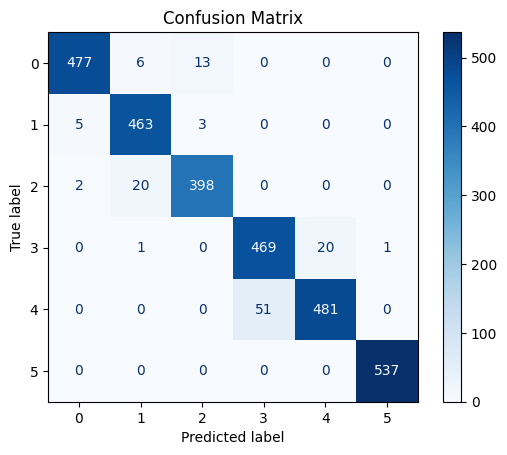

AUC Scores (per class): [0.9990491  0.9987635  0.9983078  0.99551951 0.99617678 1.        ]
Mean AUC: 0.9980


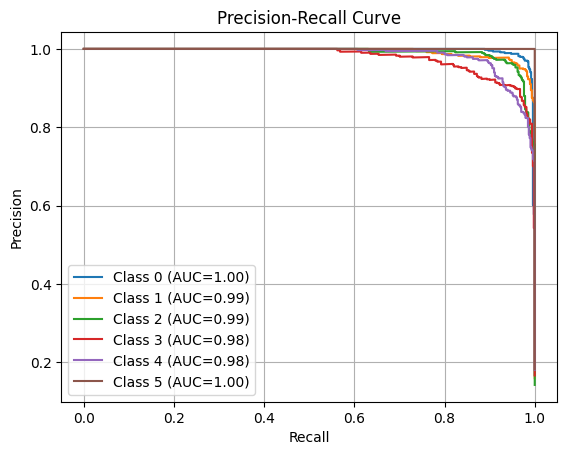

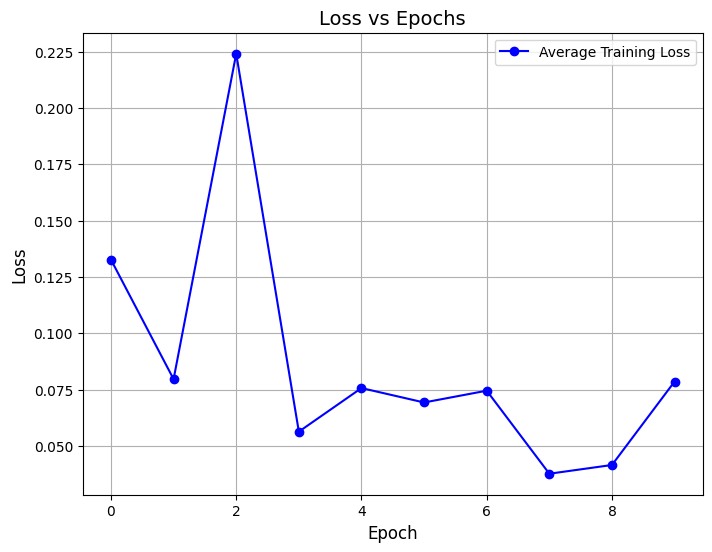

In [24]:
class FCNet(nn.Module):
    def __init__(self, input_size, num_classes=6):
        super(FCNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

input_size = X_train.shape[1]
# model = FCNet(input_size)
criterion = nn.CrossEntropyLoss()

# train(train_set, model, criterion)
# test(test_set, model)

lrs = np.linspace(0.01, 0.1, 5)

best_loss = float('inf')
best_lr = None

for lr in lrs:  
    FC_model = FCNet(input_size)
    train_losses = train(train_set, FC_model, criterion, lr=lr)
    train_loss = np.mean(train_losses)
    print(f"Learning rate: {lr:.4f}, Loss: {train_loss:.4f}")

    if train_loss < best_loss:
        best_loss = train_loss
        best_lr = lr

print(f"Best Learning Rate: {best_lr:.4f}, Best Loss: {best_loss:.4f}")

fc_model = FCNet(input_size)
train_losses = train(train_set, FC_model, criterion, lr=best_lr)
test(test_set, FC_model)

plot_loss(train_losses)

Learning rate: 0.0001, Lambda: 0.0001, Loss: 50.7013
Learning rate: 0.0001, Lambda: 0.0003, Loss: 49.2891
Learning rate: 0.0001, Lambda: 0.0006, Loss: 47.6059
Learning rate: 0.0001, Lambda: 0.0008, Loss: 47.4001
Learning rate: 0.0001, Lambda: 0.0010, Loss: 48.7372
Learning rate: 0.0003, Lambda: 0.0001, Loss: 30.2294
Learning rate: 0.0003, Lambda: 0.0003, Loss: 37.1230
Learning rate: 0.0003, Lambda: 0.0006, Loss: 37.9544
Learning rate: 0.0003, Lambda: 0.0008, Loss: 33.4295
Learning rate: 0.0003, Lambda: 0.0010, Loss: 35.1490
Learning rate: 0.0006, Lambda: 0.0001, Loss: 30.3130
Learning rate: 0.0006, Lambda: 0.0003, Loss: 31.7636
Learning rate: 0.0006, Lambda: 0.0006, Loss: 30.1439
Learning rate: 0.0006, Lambda: 0.0008, Loss: 33.6362
Learning rate: 0.0006, Lambda: 0.0010, Loss: 28.1993
Learning rate: 0.0008, Lambda: 0.0001, Loss: 45.1366
Learning rate: 0.0008, Lambda: 0.0003, Loss: 43.4187
Learning rate: 0.0008, Lambda: 0.0006, Loss: 31.7457
Learning rate: 0.0008, Lambda: 0.0008, Loss: 2

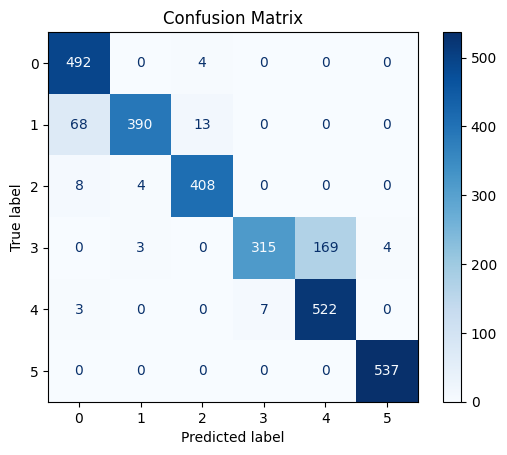

AUC Scores (per class): [0.99920375 0.99756902 0.9992811  0.99273403 0.9931786  1.        ]
Mean AUC: 0.9970


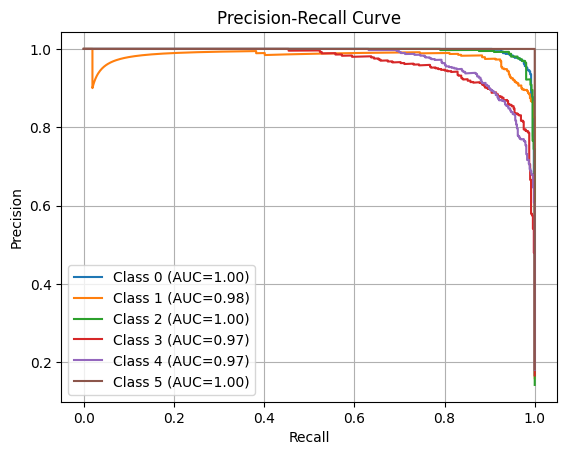

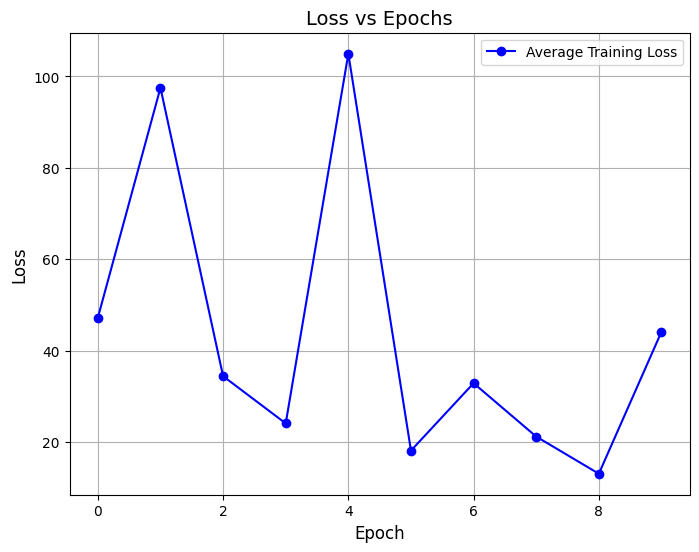

In [25]:
class SVM(nn.Module):
    def __init__(self, input_size, num_classes=6):
        super(SVM, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

def hinge_loss(output, y, model, reg_lambda):
    y_one_hot = torch.zeros_like(output)
    y_one_hot.scatter_(1, y.view(-1, 1), 1) # Convert labels 0-5 to one-hot encoding
    y_one_hot = 2 * y_one_hot - 1  # Convert to {-1, 1} for each class

    loss = torch.sum(torch.clamp(1 - y_one_hot * output, min=0))
    reg_term = reg_lambda * torch.sum(model.linear.weight ** 2)
    return loss + reg_term

input_size = X_train.shape[1]
criterion = hinge_loss

lrs = np.linspace(0.0001, 0.001, 5)
lambdas = np.linspace(0.0001, 0.001, 5)

best_loss = float('inf')
best_lr = None
best_lambda = None

for lr in lrs:
    for reg_lambda in lambdas:   
        SVM_model = SVM(input_size)
        train_losses = train(train_set, SVM_model, criterion, lr=lr, reg_lambda=reg_lambda)
        train_loss = np.mean(train_losses)
        print(f"Learning rate: {lr:.4f}, Lambda: {reg_lambda:.4f}, Loss: {train_loss:.4f}")

        if train_loss < best_loss:
            best_loss = train_loss
            best_lr = lr
            best_lambda = reg_lambda

print(f"Best Learning Rate: {best_lr:.4f}, Best Lambda: {best_lambda:.4f}, Best Loss: {best_loss:.4f}")

SVM_model = SVM(input_size)
train_losses = train(train_set, SVM_model, criterion, lr=best_lr, reg_lambda=best_lambda)
test(test_set, SVM_model)

plot_loss(train_losses)


SVM Model Accuracy: 0.9504580929759077
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       496
           1       0.93      0.96      0.94       471
           2       0.99      0.91      0.95       420
           3       0.94      0.89      0.91       491
           4       0.91      0.95      0.93       532
           5       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



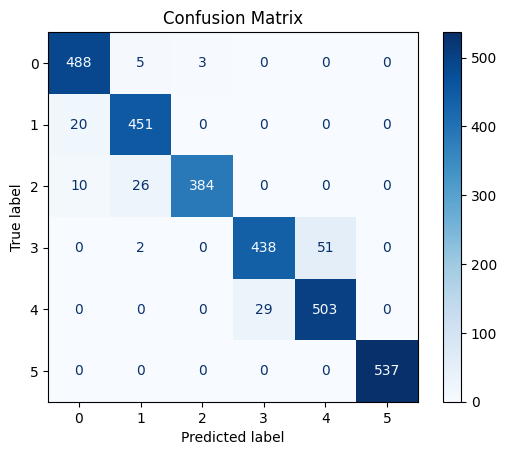

AUC Scores (per class): [0.99930492 0.99825415 0.99884015 0.99461645 0.99605069 1.        ]
Mean AUC: 0.9978


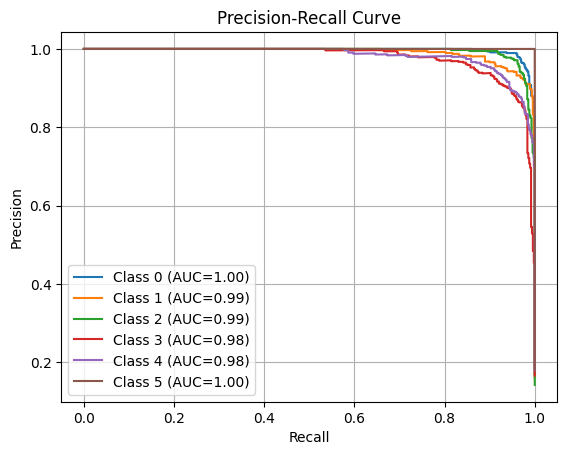

In [26]:
def sklearn_svm_model(X_train, y_train, X_test, y_test):
    sk_SVM_model = SVC(kernel='rbf', C=1.0, probability=True)
    sk_SVM_model.fit(X_train, y_train)
    sk_SVM_preds = sk_SVM_model.predict(X_test)
    sk_SVM_probs = sk_SVM_model.predict_proba(X_test)
    
    print("SVM Model Accuracy:", accuracy_score(y_test, sk_SVM_preds))
    print(classification_report(y_test, sk_SVM_preds))

    plot_confusion_matrix(y_test, sk_SVM_preds)
    plot_AUC(y_test, sk_SVM_probs)
    return sk_SVM_model

sk_SVM_model = sklearn_svm_model(X_train, y_train, X_test, y_test)


Accuracy: 0.9257
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       496
           1       0.90      0.89      0.89       471
           2       0.97      0.87      0.91       420
           3       0.91      0.89      0.90       491
           4       0.90      0.92      0.91       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.93      0.93      2947



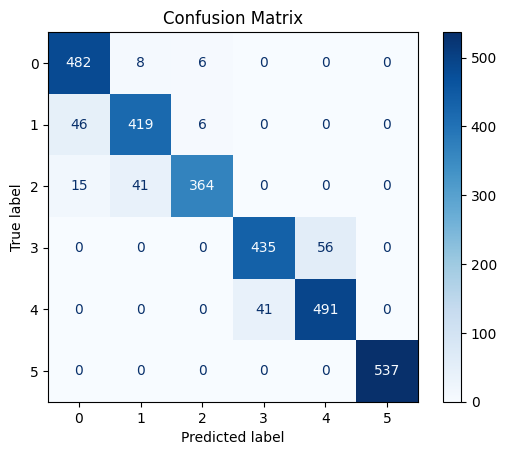

AUC Scores (per class): [0.997522   0.99111299 0.99079277 0.99563602 0.99591058 1.        ]
Mean AUC: 0.9952


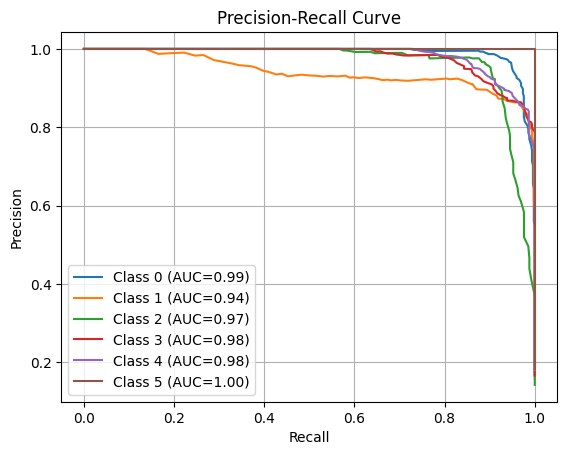

In [27]:
def sklearn_random_forest_model(X_train, y_train, X_test, y_test):
    RF_model = RandomForestClassifier(
        n_estimators=100,  # Number of trees
        max_depth=None,    # Maximum depth of trees (default)
        random_state=42    # Set for reproducibility
    )
    RF_model.fit(X_train, y_train)

    RF_pred = RF_model.predict(X_test)
    RF_prob = RF_model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, RF_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, RF_pred))

    plot_confusion_matrix(y_test, RF_pred)
    plot_AUC(y_test, RF_prob)
    return RF_model

RF_model = sklearn_random_forest_model(X_train, y_train, X_test, y_test)